## Introduction

This notebook represents my research process and implementation of reinforcement learning model, using Q learning. I would be training the model on the game from the GYM library called Taxi driver. Training the model to complete Taxi Driver  represents my ability to understand how Q-learning works, as well as the ability to adequately assess the performance of the model and adjust the hyperparameters to achieve better results, efficiently disposing matplotlib as a visualization tool. 

### Small info on Taxi Driver game:
This game is quite similar to Frozen Lake - the main goal for the agent is to navigate through tiles, find the shortest path to a passenger, pick them up and drop off in a specified location. Every turn the agent has to choose from 6 available actions (Go up, down, left, right, pick up passenger or drop off passenger).
The rewards are distributed the following way:
* **-1 per step unless other reward is triggered.**
* **+20 delivering passenger**
* **-10 executing “pickup” and “drop-off” actions illegally**
  
It is not possible to fail - main goal is to deliver the passenger and lose as less points as possble.

### Justification on choosing Taxi Driver:
This game is a parof a GYM environent and it has a lot in common with the Frozen Lake - the observation space is disc and the number of possible states is adequate (500 states possible), meaning that Q table could be created and the training won't take a long time. On the other hand, Taxi Driver has a lot of features that are different from Frozen Lake, such as rewards distribution, requiring some critical thinking and code adjustment (so I can't just copypaste code from Frozen lake and call it a day)

By now you shoud have sufficient information on the environment that I chose, so without further ado let's start with the implementation process of 

### Taxi Driver

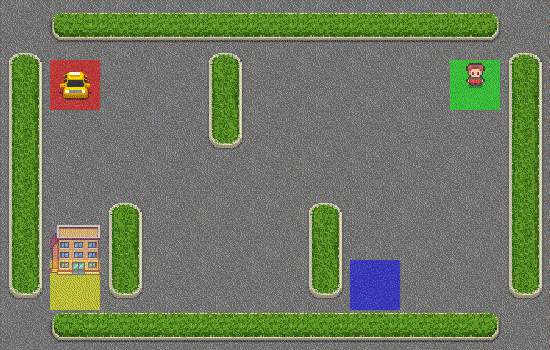

#### Step 0: Create a cell for importing all of the neccessary libraries

In [183]:
import matplotlib.pyplot as plt
import gym
import statistics
import random
import numpy as np

#### Step 1: Re-use the RL mode trained for Frozen Lake and compare the results
This step is pretty much self-explanatory - the games are similar, so the core logic behind training the model should be pretty much the same. 


Q-table after training:
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -0.58703053   0.41268205  -0.62364074   0.41670381   1.62261467
   -8.56509197]
 [  4.33970014   5.94174329   4.34779428   5.94238448   7.7147
   -3.06877217]
 ...
 [ -2.35975195   9.68165675  -0.41741629   4.14346352  -4.41008507
   -6.46207542]
 [ -0.30467955  -2.82022114  -3.82324862   2.8939447  -12.22751259
  -10.49106389]
 [ 12.9312382   11.82667569   5.26540814  16.99999356   3.64760825
    4.97808229]]


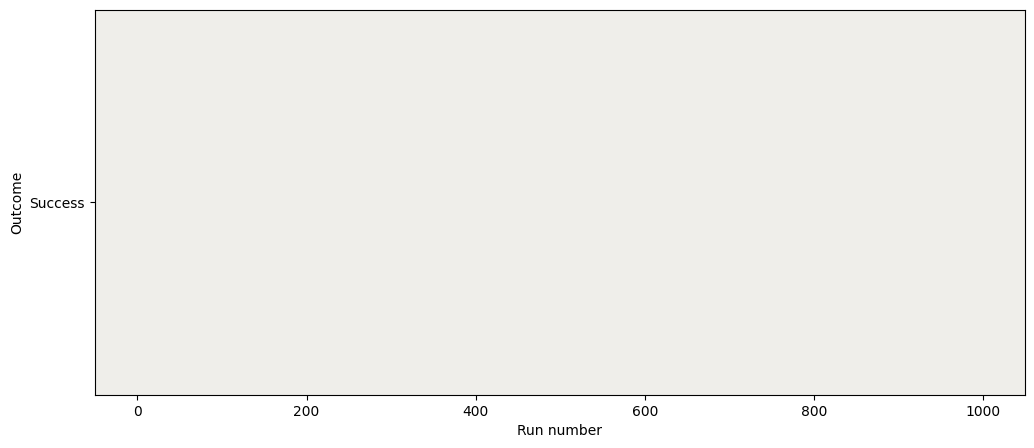

Success rate = 187.0%


In [184]:
environment = gym.make("Taxi-v3")
environment.reset()

# We re-initialize the Q-table
qtable = np.zeros((environment.observation_space.n, environment.action_space.n))

# Hyperparameters
episodes = 1000        # Total number of episodes
alpha = 0.5            # Learning rate
gamma = 0.9            # Discount factor
epsilon = 1.0          # Amount of randomness in the action selection
epsilon_decay = 0.001  # Fixed amount to decrease

# List of outcomes to plot
outcomes = []

# Training
for _ in range(episodes):
    state = environment.reset()
    done = False

    # By default, we consider our outcome to be a failure
    outcomes.append("Failure")
    
    # Until the agent gets stuck in a hole or reaches the goal, keep training it
    while not done:
        # Generate a random number between 0 and 1
        rnd = np.random.random()

        # If random number < epsilon, take a random action
        if rnd < epsilon:
          action = environment.action_space.sample()
        # Else, take the action with the highest value in the current state
        else:
          action = np.argmax(qtable[state])
             
        # Implement this action and move the agent in the desired direction
        new_state, reward, done, info = environment.step(action)

        # Update Q(s,a)
        qtable[state, action] = qtable[state, action] + \
                                alpha * (reward + gamma * np.max(qtable[new_state]) - qtable[state, action])
        
        # Update our current state
        state = new_state

        # If we have a reward, it means that our outcome is a success
        if reward:
          outcomes[-1] = "Success"

    # Update epsilon
    epsilon = max(epsilon - epsilon_decay, 0)

print()
print('===========================================')
print('Q-table after training:')
print(qtable)

# Plot outcomes
plt.figure(figsize=(12, 5))
plt.xlabel("Run number")
plt.ylabel("Outcome")
ax = plt.gca()
ax.set_facecolor('#efeeea')
plt.bar(range(len(outcomes)), outcomes, color="#0A047A", width=1.0)
plt.show()

episodes = 100
nb_success = 0

# Evaluation
for _ in range(100):
    state = environment.reset()
    done = False
    
    # Until the agent gets stuck or reaches the goal, keep training it
    while not done:
        # Choose the action with the highest value in the current state
        action = np.argmax(qtable[state])

        # Implement this action and move the agent in the desired direction
        new_state, reward, done, info = environment.step(action)

        # Update our current state
        state = new_state

        # When we get a reward, it means we solved the game
        nb_success += reward

# Let's check our success rate!
print (f"Success rate = {nb_success/episodes*100}%")

#### Takeaways:
1. The visualization part should be changed, as Taxi Driver game doesn't have Success or Failure Criteria
2. The Q table was updated with values, which means that the whole system works
3. The calculation of success should be changed as well - now it outputs an incorrect value
4. I should think of a new visualization system that would indicate the progress that the model makes per episode

#### Step 2: Defining the quality metrics 
Again, it's not possible to lose, so it would be a better decision to measure agent's success by the amount of gained points. Higher amount of points would mean that the agent is able to solve task quickly, since the score decreases by 1 with each step.
It would also be useful to see how many steps the agent took before dropping the passenger off - this graph would be different from "average score", since the agent can also lose 10 points by choosing "pick-up/drop-off" actions in the wrong place. Finally, the amount of illegal actions taken per session should also be considered, as it directly represents how quickly the model reacts to negative rewards.

#### Step 3: Proper visualization effort
Now it's time to visualize all of the quality metrics mentioned above, by modifying the code and creating plots using matplotlib. I've introduced three new lists that would store the following values per each episode:
**a) Average score**
**b) Amount of illegal actions**
**c) Steps to complete the game**
Inside of the "for" loop responsible for iterating through the episodes new variables would be initialised that track the quality metrics and add them to a corresponding list in the end of each loop
After the training process three barplots corresponding to each quality metric would be created
The modified code looks like this:

In [185]:

# Hyperparameters
episodes = 1000   # Total number of episodes
alpha = 0.75        # Learning rate
gamma = 0.9     # Discount factor
epsilon = 0.4  # Amount of randomness in the action selection
epsilon_decay = 0.0002 # Fixed amount to decrease


In [186]:
def plot_quality_metric(quality_metric, metric_name, episodes):
    episode_array = [1 + i for i in range(episodes)]
    # Plot outcomes
    plt.figure(figsize=(9, 4))
    plt.xlabel("Run number")
    plt.ylabel(metric_name)
    ax.set_facecolor('#efeeea')
    plt.plot(episode_array, quality_metric)
    plt.show()

def run_training_iteration(epsilon, episodes, alpha, gamma, epsilon_decay):
    environment = gym.make('Taxi-v3')
    qtable = np.zeros((environment.observation_space.n, environment.action_space.n))
    #lists for measuring quality metrics
    average_reward_per_episode = []
    steps_to_finish_the_game = []
    illegal_actions_list = []
    
    # Training
    for _ in range(episodes):
    
        #logging all rewards here, to calculate mean value later
        points_per_episode = []
        step_number = 0
        illegal_actions = 0
        state = environment.reset()
        done = False
         
        # By default, we consider our outcome to be a failure
        
        # Until the agent gets stuck in a hole or reaches the goal, keep training it
        while not done:
            # Generate a random number between 0 and 1
            rnd = np.random.random()
            
            # If random number < epsilon, take a random action
            if rnd < epsilon:
              action = environment.action_space.sample()
            # Else, take the action with the highest value in the current state
            else:
              action = np.argmax(qtable[state])
                 
            # Implement this action and move the agent in the desired direction
            new_state, reward, done, info = environment.step(action)
    
            # Update Q(s,a)
            qtable[state, action] = qtable[state, action] + \
                                    alpha * (reward + gamma * np.max(qtable[new_state]) - qtable[state, action])
            
            # Update our current state
            state = new_state
            points_per_episode.append(reward)
            
            step_number = step_number + 1
            
            # check for commiting an illegal actioj
            if reward == -10:
                illegal_actions = illegal_actions + 1

        #make sure that epsilon value wouldn't be negative
        if epsilon > 0: 
        # Update epsilon
            epsilon = max(epsilon - epsilon_decay, 0)
    
        #keep track of average reward in the end of the episode
        awerage_reward = statistics.mean(points_per_episode)
        average_reward_per_episode.append(awerage_reward)
    
        #track steps
        steps_to_finish_the_game.append(step_number)
        
        illegal_actions_list.append(illegal_actions)
    
    print()
    print('===========================================')
    print('Q-table after training:')
    print(qtable)
    return steps_to_finish_the_game, illegal_actions_list, average_reward_per_episode





Q-table after training:
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -0.588843     0.45610393  -0.75460207   0.45537891   1.62261467
   -8.54052755]
 [  3.83804096   5.30840991   1.40095292   5.87497867   7.7147
   -3.06344967]
 ...
 [  3.1458884    9.67838172   6.76592807  -2.77637329  -7.5
   -3.7038758 ]
 [ -4.6455546   -4.73823939  -4.74945204   2.8840609  -10.86199072
  -13.04858632]
 [ 14.05129394  11.60983175  -1.44375     17.           2.1
   -9.88125   ]]


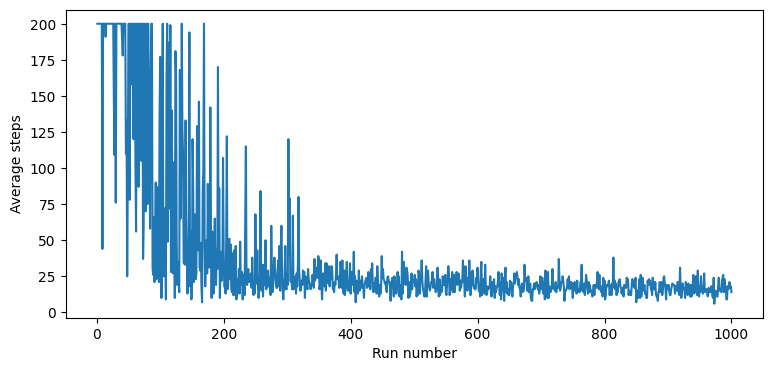

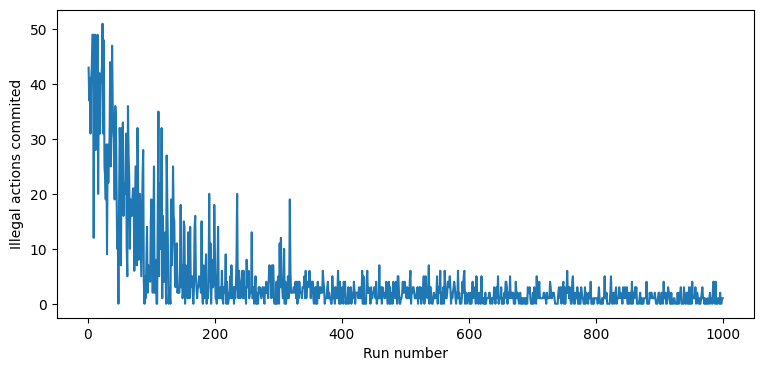

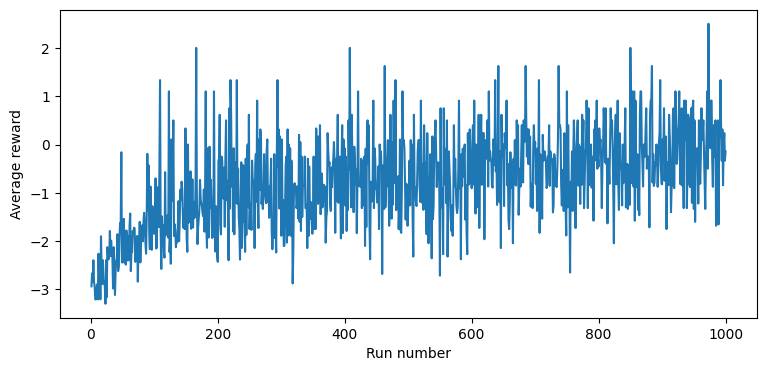

In [187]:
steps, illegal_actions, avg_reward = run_training_iteration(epsilon, episodes, alpha, gamma, epsilon_decay)
plot_quality_metric(steps, "Average steps", episodes)
plot_quality_metric(illegal_actions, "Illegal actions commited", episodes)
plot_quality_metric(avg_reward, "Average reward", episodes)

#### Takeaways from plots:
* The training process functions properly, as the amount of steps to complete the game decreases over time, while average score increases
* The model quickly grasps that taking illegal actions should be avoided
* The model reaches it's peak performance roughly after 300-350 episodes

#### Step 4: Tuning the hyperparameters
Since we now have a reliable and informative visualization system, it's time to tune the hyperparameters in order to achieve even better results. 
First of all, the amount of the episodes should be decreased to 500, as the model doesn't seem to improve beyond this point.
Currently the epsilon value, which represents exploration-exploitation rate is set to 0.4, meaning that the model has a 40% chance to perform a random action.
It would be interesting to change it and run two more iterations where epsilon value would be:

**Iteration 1: Much higher (epsilon = 0.8) but epsilon decay would also be bigger (0.0005).**
**Iteration 2: Much lower (epsilon = 0.12) and the decay value would remain the same (0.0001)**

I am also going to slightly increase learning rate to 0.8 and decrease the discount factor to 0.85 to understand it's influence on model's performance.


In [188]:
episodes = 500 #decrease the amount of episodes
alpha = 0.8        # Increase and check the influence
gamma = 0.85    # Decrease and check the influence
high_epsilon = 0.8
high_decay = 0.0005 #5x times more than previous decay
low_epsilon = 0.12
low_decay = epsilon_decay

#### Step 5: Extra visualization effort 
For convenience, I would plot the values from iteration 1 and iteration 2 on one graph, writing a new visualization function for it

In [189]:
def plot_two_graphs(iteration_low, iteration_high, y_label, legend2, legend1):
    # Plot outcomes
    episode_array = [1 + i for i in range(episodes)]
    plt.figure(figsize=(9, 4))
    plt.xlabel("Run number")
    plt.ylabel(y_label)
    ax.set_facecolor('#efeeea')
    plt.plot(episode_array, iteration_high, 'orange', label = legend2)
    plt.plot(episode_array, iteration_low, 'lightsteelblue', label = legend1)
    plt.legend(loc="upper right")
    plt.show()



Q-table after training:
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -2.66343462  -1.74327794  -4.55694641  -3.04866389  -0.49021477
  -12.10281352]
 [  0.89275352  -3.24440515  -0.14755135  -3.14845389   5.165475
   -8.        ]
 ...
 [ -3.14845389   6.52574185  -3.14845389  -3.48857975  -8.
   -8.        ]
 [ -4.03132828  -3.67582701  -4.26910317  -4.15434778  -8.
   -8.        ]
 [ -1.504       -1.504       -1.504       15.7559296   -8.
   -8.        ]]

Q-table after training:
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -2.99753437  -1.43991915  -2.55629767  -1.44461137  -0.49021477
  -10.51912832]
 [  1.88158207   3.38828789   1.88205568   3.39064775   5.165475
   -5.60934626]
 ...
 [  1.87497547   3.33563335   1.32169747   3.39065375  -7.2836237
   -7.67847647]
 [ -1.15311063  -0.40327994  -4.09768143   0.59968929 -10.73248704
  -10.88824422]
 [ 12.59999814   9.70643499  12.59996745  16.           3.59994352
    

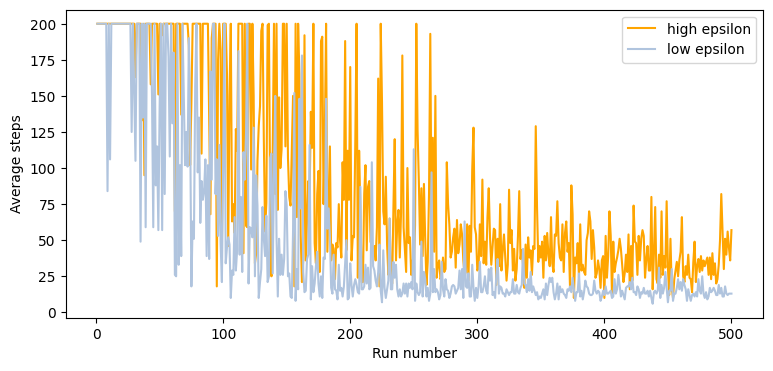

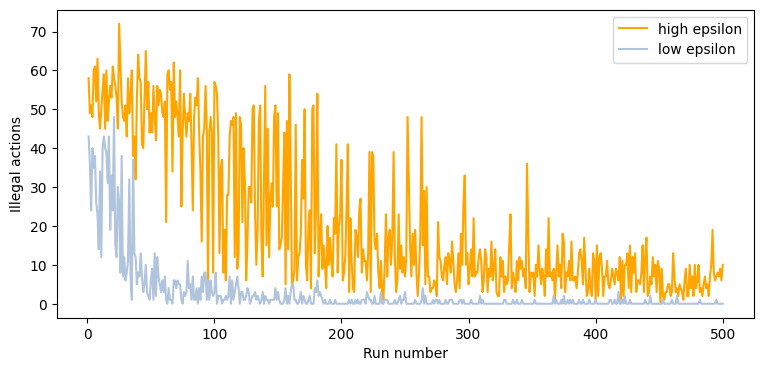

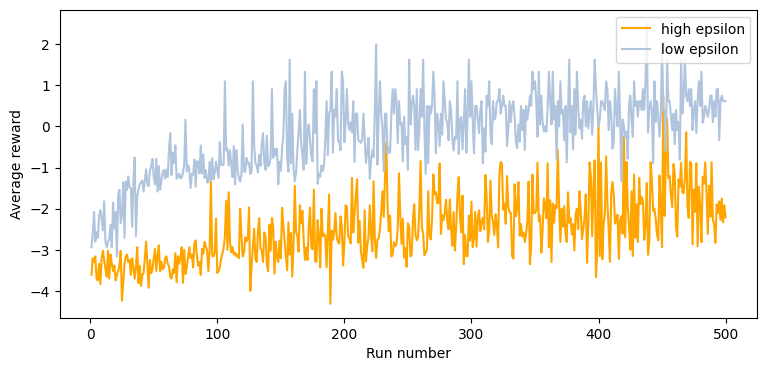

In [190]:
steps_low, illegal_actions_low, scores_low = run_training_iteration(low_epsilon, episodes, alpha, gamma, low_decay)
steps_high, illegal_actions_high, scores_high = run_training_iteration(high_epsilon, episodes, alpha, gamma, high_decay)
plot_two_graphs(steps_low, steps_high, "Average steps", "high epsilon", "low epsilon")
plot_two_graphs(illegal_actions_low, illegal_actions_high, "Illegal actions", "high epsilon", "low epsilon")
plot_two_graphs(scores_low, scores_high, "Average reward", "high epsilon", "low epsilon")

Interestingly enough, the model performs significantly better with lower epsilon value and low epsilon decay. 
My explanation is the following: this happens because high epsilon value means high chance of randomness, meaning that the model has a high chance to randomly choose an illegal action and lose a lot of points, regardless of what it have learned. 
On the other hand the model with low epsilon value makes a lot of mistakes in the beginning, but since the chance of choosing random action is low, the model's decisions have much more weight, allowing it to adapt and apply the gained knowledge.

#### Step 6: Additional hyperparameter tuning
It's time to do some extra research, tweak a few more aspects and observe the changes.
First, I'd like to see how switching from argmax to softmax would influence the training process. I'll slightly modify the code, so that the training function would have a bool value 'is_softmax', which, if set to "true", would apply softmax function to the q table. For convenience, I would only work with average reward graph now, as it directly shows model's success
Let's see what is going to change now:

In [191]:
from numpy import exp

    
def softmax_apply(vector):
 e = exp(vector)
 return e / e.sum()

def run_training_iteration(epsilon, episodes, alpha, gamma, epsilon_decay, is_softmax):
    environment = gym.make('Taxi-v3')
    qtable = np.zeros((environment.observation_space.n, environment.action_space.n))
    #lists for measuring quality metrics
    average_reward_per_episode = []
    steps_to_finish_the_game = []
    illegal_actions_list = []
    # Training
    for _ in range(episodes):
    
        #logging all rewards here, to calculate mean value later
        points_per_episode = []
        step_number = 0
        illegal_actions = 0
        state = environment.reset()
        done = False
         
        # By default, we consider our outcome to be a failure
        
        # Until the agent gets stuck in a hole or reaches the goal, keep training it
        while not done:
            # Generate a random number between 0 and 1
            rnd = np.random.random()
            
            # If random number < epsilon, take a random action
            if rnd < epsilon:
              action = environment.action_space.sample()
            # Else, take the action with the highest value in the current state
            else:
              action = np.argmax(qtable[state])
                 
            # Implement this action and move the agent in the desired direction
            new_state, reward, done, info = environment.step(action)

            qtable[state, action] = qtable[state, action] + \
                                    alpha * (reward + gamma * np.max(qtable[new_state]) - qtable[state, action])

            #apply softmax function
            if is_softmax: 
                qtable[state,action] = softmax_apply(qtable[state, action])
            # Update our current state
            state = new_state
            points_per_episode.append(reward)
            
            step_number = step_number + 1
            
            # check for commiting an illegal action
            if reward == -10:
                illegal_actions = illegal_actions + 1

        #make sure that epsilon value wouldn't be negative
        if epsilon > 0: 
        # Update epsilon
            epsilon = max(epsilon - epsilon_decay, 0)
    
        #keep track of average reward in the end of the episode
        awerage_reward = statistics.mean(points_per_episode)
        average_reward_per_episode.append(awerage_reward)
    
        #track steps
        steps_to_finish_the_game.append(step_number)
        
        illegal_actions_list.append(illegal_actions)
    
    print()
    print('===========================================')
    print('Q-table after training:')
    print(qtable)
    return average_reward_per_episode





Q-table after training:
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -2.20418018  -1.41669059  -2.20418056  -1.41668255  -0.49021477
  -10.41668255]
 [  1.88205569   3.39065375   1.88205569   3.39065375   5.165475
   -5.60934625]
 ...
 [  5.0126395    7.25341149   4.28956948   3.390336   -11.49859232
   -7.97255922]
 [ -0.52100322   0.37901273  -1.25884757   0.59974733  -9.49040721
   -9.49551154]
 [ 12.5998103    9.7096136   12.59996347  16.           3.59436085
    3.5072    ]]

Q-table after training:
[[0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 ...
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0.]]


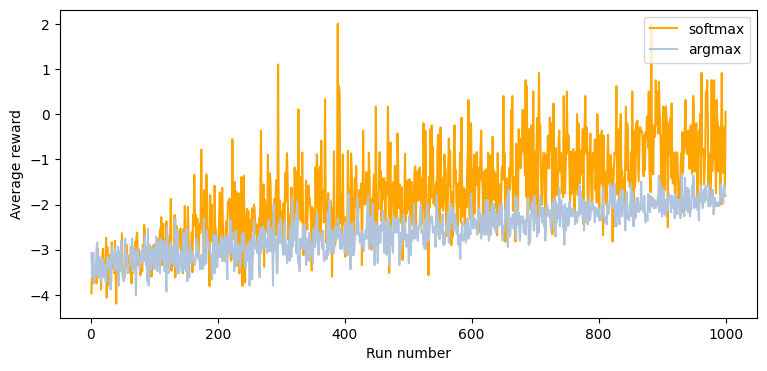

In [192]:
episodes = 1000 #increase the number of episodes to see differences in performance better
scores_argmax = run_training_iteration(high_epsilon, episodes, alpha, gamma, high_decay, False)
scores_softmax = run_training_iteration(high_epsilon, episodes, alpha, gamma, high_decay, True)
plot_two_graphs(scores_softmax, scores_argmax, "Average reward", "softmax", "argmax")

After applying softmax function, the values in the q-table are either 0 or 1. This has resulted in better model performance, but also much more value fluctuations.

#### Step 7 Testing different craving values:
Currently the model has a relatively high discount factor value of 0.85, meaning that it prioritizes immediate rewards slightly more than future rewards. Let's change the discount value to 0.2 - this should change the model's behaviour drastically, since it would choose immediate rewards much more often.


Q-table after training:
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -2.20418034  -1.41668257  -2.20418017  -1.41668255  -0.49021477
  -10.41668255]
 [  1.88205569   3.39065311   1.88205569   3.39065374   5.165475
   -5.60934625]
 ...
 [  3.62031348   7.2535      -2.55156118   3.34578896  -3.85266694
   -3.84403094]
 [ -4.01646734   0.56428591  -0.50623807   0.59974491 -10.27012632
   -9.65918712]
 [ 12.59981898   9.70999976  12.59982638  16.           3.59999859
    3.6       ]]

Q-table after training:
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -1.24999956  -1.24999782  -1.24999956  -1.24999782  -1.24998912
  -10.24999782]
 [ -1.249728    -1.24864     -1.249728    -1.24864     -1.2432
  -10.24864   ]
 ...
 [ -1.24320002  -1.216       -1.24320042  -1.24863984 -10.2432
  -10.2432    ]
 [ -1.24998589  -1.2499456   -1.24998468  -1.24994839 -10.24994239
  -10.24998869]
 [ -0.4         -1.08        -0.40000192   3.       

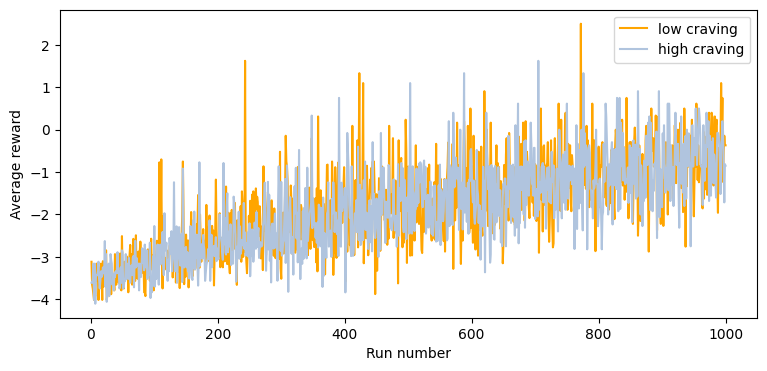

In [193]:
low_gamma = 0.2 #low discount factor value
high_discount_score = run_training_iteration(high_epsilon, episodes, alpha, gamma, high_decay, False)
low_discount_score = run_training_iteration(high_epsilon, episodes, alpha, low_gamma, high_decay, False)
plot_two_graphs(low_discount_score, high_discount_score, "Average reward", "low craving", "high craving")

The valiues in the Q-table have changed, but only to small extent, and it seems that the performance was not affected by the change. I believe that this happens due to the fact that the values in the Q-table are mostly negative, so there's not much to 'crave' so to speak 😁

### Final conclusions:
* Low epsilon values significantly improve models performance due to the low chance of choosing an illegal action unconsciously
* Softmax function improves performance but creates more fluctuations
* Discount factor doesn't play a big role in the training process
* The model learns on it's mistakes - the average reward in the last episode is 3 times higher than in the first episode

#### Original jupyter notebook could be found here: 